In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sigmaclip as sigmaclip
from scipy.interpolate import interp1d
import astropy.constants as const
from tqdm.notebook import tnrange
from scipy.optimize import curve_fit

from function import med_n_lim

import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading SYSREM results

numorder, numframe, numwv, n_sys = 22, 56, 4080, 10

#for propagation error
flux_data = np.zeros((numorder,n_sys+1,numframe,numwv))
error_data = flux_data.copy()
wave_data = flux_data.copy()
a_data = np.zeros((numorder,n_sys+1,numframe))
c_data = np.zeros((numorder,n_sys+1,numwv))

for order in range(numorder):
    for sysiter in range(n_sys+1):

    #reading hdf5 file for each SYSREM iteration
        with h5py.File('data/hdf5/HD149026b-after-#'+str(sysiter)+'-SYSREM-iteration-sys.hdf5', 'r') as h5f_raw:

            flux_data[order,sysiter] = h5f_raw['flux-order-'+str(order)][()]
            error_data[order,sysiter] = h5f_raw['error-poisson-order-'+str(order)][()]
            wave_data[order,sysiter] = h5f_raw['wv-vac-order-'+str(order)][()]
            airmass = h5f_raw['airmass'][()]
            rvcor = h5f_raw['rv_cor'][()]
            bjd = h5f_raw['bjd'][()]
            mjd = h5f_raw['mjd'][()]
            phase = h5f_raw['phase'][()]
            rel_phase = h5f_raw['rel_phase'][()]
            hour_phase = h5f_raw['hour_phase'][()]
            exptime = h5f_raw['exp_time'][()]
            out_transit_mask = h5f_raw['out_transit_mask'][()]
            transit_weight = h5f_raw['transit_weight'][()]
            carm_order = h5f_raw['carm_order'][()]
            contact_index = h5f_raw['contact_index'][()]

            if sysiter != 0:
                a_data[order,sysiter-1] = h5f_raw['a-coeff-order-'+str(order)][()]
                c_data[order,sysiter-1] = h5f_raw['c-coeff-order-'+str(order)][()]

In [3]:
def kpvsys_calc(Kp, Vsys, RV, data, vsys_planet, orb_phase, RV_bary, mask):

    """
    Interpolate CCF values to a range of Kp and Vsys

    Args:
        kp          : K_p sample in km/s
        vsys        : V_sys sample in km/s
        drvs        : RV sample in km/s
        data        : Cross-correlation values to be interpolated (frame x RV)
        vsys_planet : The expected V_sys of the planet
        orb_phase   : Orbital phase of the planet
        brv         : Correction for barycentric velocity
        mask        : A mask for out-transit frames

    Return:
        summed      : Interpolated CCF values
    """

    data = data[mask]
    orb_phase = orb_phase[mask]
    RV_bary = RV_bary[mask]

    kpvsys_frame = np.zeros([Kp.size] + [data.shape[0]] + [Vsys.size])
    for kp_idx,kp in enumerate(Kp):

        # aligning the in-trail CCF to the planetary rest-frame (Vsys ~ 0 km/s)
        RV_predict = kp * np.sin(2. * np.pi * orb_phase) + RV_bary + vsys_planet

        for phase_idx in range(orb_phase.size):
            kpvsys_frame[kp_idx,phase_idx] = interp1d(RV,data[phase_idx],kind='linear')(RV_predict[phase_idx] + Vsys)

    kpvsys_map = kpvsys_frame.sum(axis=1)
    return kpvsys_map

def fitting_histogram(distribution,plot=True):

    # making the histogram
    num_bins = int(1 + 3.322*np.log10(len(distribution))) # following Sturge's rule
    hist_ = plt.hist(distribution,histtype="step",align='mid',bins=num_bins)

    # assigning the value of each bin and the x-axis of the bin itself ~ (right_edge+left_edge)/2
    x_hist_edges,y_hist = hist_[1],hist_[0]
    x_hist = (x_hist_edges[:-1] + x_hist_edges[1:])/2

    # calculating the Gaussian PDF values given Gaussian parameters and random variable X
    def gaus(X, C, X_mean, sigma):
        return C * np.exp(-(X - X_mean)**2 / (2 * sigma**2))
    
    # calculate the mean and standard deviation
    # the standard deviation is the square root of the variance of the distribution, which is defined as the average of the squared differences of the data from the mean.
    mean = sum(x_hist * y_hist) / sum(y_hist)
    sigma = sum(y_hist * (x_hist-mean)**2) / sum(y_hist)

    # Gaussian least-square fitting process
    # the constant C is just a normalization factor, so we can use the maximum value of the distribution
    param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)

    # plotting the histogram
    if plot:
        plt.hist(distribution,histtype="step",align='mid',bins=num_bins)
        plt.plot(x_hist,y_hist,label='data')
        plt.plot(x_hist,gaus(x_hist,*param_optimised),label='fit')
        plt.legend()
        plt.show()
        plt.clf()

    # print fit Gaussian parameters
    print("Fit parameters: ")
    print("=====================================================")
    print("C = ", param_optimised[0], "+-", np.sqrt(param_covariance_matrix[0, 0]))
    print("X_mean =", param_optimised[1], "+-", np.sqrt(param_covariance_matrix[1, 1]))
    print("sigma = ", param_optimised[2], "+-", np.sqrt(param_covariance_matrix[2, 2]))
    print("\n")

    return np.abs(param_optimised[2])

In [4]:
# function for cross-correlating model with data, creating Kp-Vsys map, and calculating log-likelihood  mapping
def detect_molecules(wavedat, fluxdat, errordat, wave_modelmol, flux_modelmol,
                     sys_iter, carm_order,
                     RV_sample, Kp_sample, Vsys_sample, A_sample,
                     Kp_planet, Vsys_planet,
                     transit_weight, out_transit_mask, rvcor, phase, rel_phase,
                     std_brogi=True, plot=True, 
                     thold_kp=150, thold_vsys=10, dpi=100,neg_Kp=False):

    CC_total_norm_final = []
    CC_shifted_final = []
    CC_combine_final = []
    SN_map_final = []
    SN_map_final_std = []
    Likelihood_F_final = []
    # for sys_iter in range(sysrem_iteration):

    #     if sys_iter == 1:

            # print('################ SYSREM '+str(sys_iter)+' #####################')
            
    K1_all,K2_all,CC_all,N_data = [],[],[],[]
    for idx,order in enumerate(carm_order):

        flux_obs = fluxdat[idx][sys_iter].copy()
        wave_obs = wavedat[idx][sys_iter].copy()
        error_obs = errordat[idx][sys_iter].copy()

        # masking model to the corresponding order wavelength
        masktemp = (wave_modelmol > wave_obs[0][0] - 20) * (wave_modelmol < wave_obs[0][-1] + 20)
        wave_mod,flux_mod = wave_modelmol[masktemp],flux_modelmol[masktemp]

        # Doppler-shift the model (RV_sample x wavelength)
        wave_mod_shifted = wave_obs[0][np.newaxis,:] / (1 + RV_sample*1000/const.c.value)[:,np.newaxis]
        flux_mod_shifted = np.interp(wave_mod_shifted,wave_mod,flux_mod)

        # putting the Doppler-shifted model into common continuum level
        flux_mod_shifted -= np.nanmedian(flux_mod_shifted,axis=1)[:,np.newaxis]
        maskpix = error_obs[0]!=np.inf
        for frame in range(error_obs.shape[0]):
            flux_obs[frame][maskpix==True] = flux_obs[frame][maskpix] - np.nanmedian(flux_obs[frame][maskpix])

        # calculating the summation terms in the chi^2 equation
        K1 = np.nansum(flux_obs**2/error_obs**2,axis=1)
        K2 = np.dot(1./error_obs**2,(flux_mod_shifted**2).T)
        CC = np.dot(flux_obs/error_obs**2,flux_mod_shifted.T)

        K1_all.append(K1)
        K2_all.append(K2)
        CC_all.append(CC)
        N_data.append(len(wave_obs[0]))

    # summing over orders
    K1_total = np.sum(K1_all,axis=0)
    K2_total = np.sum(K2_all,axis=0)
    CC_total = np.sum(CC_all,axis=0)
    Ndata_total = np.sum(N_data)

    # normalizing
    CC_total_norm = CC_total - np.nanmedian(CC_total,axis=1)[:,np.newaxis]

    # expected RV path
    RV_planet = Kp_planet * np.sin(2. * np.pi * phase) + (-rvcor) + Vsys_planet

    # shifting to planetary rest frame
    CC_shifted = np.zeros([phase.size] + [Vsys_sample.size])
    for frame in range (phase.size):
        CC_shifted[frame] = interp1d(RV_sample,CC_total_norm[frame])(RV_planet[frame] + Vsys_sample)

    # # in-trail distribution --> +- 15 pixels from the expected RV path
    # rvp_min = RV_planet - sampling * 15
    # rvp_max = RV_planet + sampling * 15
    # out_trail_telrestframe, out_trail_planetrestframe = [],[]
    # for ph in range(len(phase[out_transit_mask>0])):
    #     for idx_rv,rv in enumerate(RV_sample):
    #         if not (rv < rvp_max[ph] and rv > rvp_min[ph]): out_trail_telrestframe.append(CC_total_norm[out_transit_mask>0][ph][idx_rv])
    #     for idx_rv,rv in enumerate(Vsys_sample):
    #         if not (rv < + sampling * 15 and rv > - sampling * 15): out_trail_planetrestframe.append(CC_shifted[out_transit_mask>0][ph][idx_rv])

    # CC_std = fitting_histogram(out_trail_telrestframe)
    # CC_std = fitting_histogram(out_trail_planetrestframe)
    
    # combine weighted values over time
    CC_combine = np.sum(CC_shifted * transit_weight[:,np.newaxis], axis=0)

    CC_total_norm_final.append(CC_total_norm)
    CC_shifted_final.append(CC_shifted)
    CC_combine_final.append(CC_combine)

    # note: transit_weight acts like scale factor on the chi^2 computation (K1 not weighted, K2 weighted by squared)*transit_weight[:,np.newaxis]
    # note: barycentric RV should be given in negative due to the signing adoption of CARMENES pipeline (see e.g., Webb+ 2022)
    CC_all_kpvsys = kpvsys_calc(Kp_sample,Vsys_sample,RV_sample,CC_total*transit_weight[:,np.newaxis]\
                    ,Vsys_planet,np.array(phase),-np.array(rvcor),out_transit_mask>0)
    K2_all_kpvsys = kpvsys_calc(Kp_sample,Vsys_sample,RV_sample,K2_total*np.square(transit_weight[:,np.newaxis])\
                    ,Vsys_planet,np.array(phase),-np.array(rvcor),out_transit_mask>0)
    K1_all_kpvsys = K1_total[out_transit_mask>0].sum()
    Ndata_total *= len(out_transit_mask[out_transit_mask>0]) # multiply by the number of in-transit frames

    # index of the location of the expected planet location
    vsys_expect = (np.abs(Vsys_sample - 0)).argmin() # since the Kp-Vsys map is in the planet rest-frame (see the kpvsys_calc function)
    kp_expect = (np.abs(Kp_sample - Kp_planet)).argmin()

    ################################## Kp-Vsys Map ##################################

    # CC for Kp-Vsys map (must be normalised)
    CC_all_kpvsys_norm = kpvsys_calc(Kp_sample,Vsys_sample,RV_sample,CC_total_norm*transit_weight[:,np.newaxis]\
                    ,Vsys_planet,np.array(phase),-np.array(rvcor),out_transit_mask>0)
    
    # index of maximum value in the Kp-Vsys map
    kp_snmax,vsys_snmax = np.unravel_index(CC_all_kpvsys_norm.argmax(),CC_all_kpvsys_norm.shape)

    # masking the maximum signal in the map (+-thold)
    masked_peak = CC_all_kpvsys_norm != np.inf
    kp_maskpeak = np.digitize([Kp_sample[kp_snmax] - thold_kp, Kp_sample[kp_snmax] + thold_kp], Kp_sample)
    vsys_maskpeak = np.digitize([Vsys_sample[vsys_snmax] - thold_vsys, Vsys_sample[vsys_snmax] + thold_vsys], Vsys_sample)
    masked_peak[kp_maskpeak[0]:kp_maskpeak[-1],vsys_maskpeak[0]:vsys_maskpeak[-1]] = False

    # masking telluric region Kp ~ 0-50 km/s for all Vrest
    if not neg_Kp:
        kp_tel = (np.abs(Kp_sample - 50)).argmin()
        masked_peak[:kp_tel,:] = False
    else:
        kp_tel = (np.abs(Kp_sample + 50)).argmin()
        masked_peak[kp_tel:,:] = False
    
    # choosing between using std calculation from Brogi or the conventional
    if not std_brogi:
        # map_std = kpvsys_sigma_conventional(CC_all_kpvsys_norm,Kp_sample,Vsys_sample,kp_snmax,vsys_snmax,kp_negative)
        map_std = np.std(CC_all_kpvsys_norm[masked_peak])
    else:
        map_std = fitting_histogram(CC_all_kpvsys_norm[masked_peak],plot=plot)

    SN_map = CC_all_kpvsys_norm / map_std
    SN_map_final.append(SN_map)
    # SN_map_final.append(CC_all_kpvsys_norm)
    SN_map_final_std.append(map_std)

    # ################################## Likelihood Computation ##################################

    # compute chi^2
    chi2_total = K1_all_kpvsys + A_sample[:,np.newaxis,np.newaxis]**2. * K2_all_kpvsys[np.newaxis,...] -\
                2. * A_sample[:,np.newaxis,np.newaxis] * CC_all_kpvsys[np.newaxis,...]

    # compute likelihood
    logL = -Ndata_total / 2 * np.log(chi2_total / Ndata_total)
    Likelihood_F = np.exp(logL-np.max(logL))

    Likelihood_F_final.append(Likelihood_F)

    # marginilising Kp, Vsys, and alpha
    Kp_marg = Likelihood_F.sum(axis=(0,2)) #for Kp
    Vsys_marg = Likelihood_F.sum(axis=(0,1)) #for Vsys
    A_marg = Likelihood_F.sum(axis=(1,2)) #for alpha
    
    # compute the median and 1-sigma value of the posterior and corresponding parameter value
    std_A_low,med_A,std_A_high = med_n_lim(A_sample,A_marg)
    std_vsys_low,med_vsys,std_vsys_high = med_n_lim(Vsys_sample,Vsys_marg)
    std_kp_low,med_kp,std_kp_high = med_n_lim(Kp_sample,Kp_marg)

    # conditional likelihood at maximum signal
    A_cond = Likelihood_F[:,np.argmax(Kp_marg),np.argmax(Vsys_marg)]
    std_Ac_low,med_Ac,std_Ac_high = med_n_lim(A_sample,A_cond)

    if plot:

        colorm = 'viridis'
        cmap = plt.get_cmap(colorm)
        cmap.set_bad(color = 'white', alpha = 1.)
        
        ################################### CC map ################################### 

        axes_rvmap = [0, 0, 0.4, 0.6]
        axes_vsysmap = [0 + 0.4, 0, 0.3, 0.6]
        axes_cccombcurve = [0 + 0.4 + 0.3 + 0.02, 0, 0.2, 0.6]

        fig = plt.figure(figsize=(10, 4),dpi=dpi)
        rvmap = plt.axes(axes_rvmap)
        vsysmap = plt.axes(axes_vsysmap)
        cccombcurve = plt.axes(axes_cccombcurve)

        frames = rel_phase  #np.arange(len(rel_phase))

        rvmap.pcolormesh(RV_sample, frames, CC_total_norm, cmap=cmap)
        rvmap.set_ylabel("Frame number")
        rvmap.set_xlabel("RV (km/s)")
        # rvmap.plot((RV_planet[0], RV_planet[contact_index[0]]), (frames[0], frames[contact_index[0]]), ls='--', color='red', alpha=1, lw=1)
        # rvmap.plot((RV_planet[-1], RV_planet[contact_index[3]]), (frames[-1], frames[contact_index[3]]), ls='--', color='red', alpha=1, lw=1)
        # rvmap.axhline(y=frames[contact_index[0]], c="white", lw=1, alpha=1, ls="--")
        # rvmap.axhline(y=frames[contact_index[1]], c="white", lw=1, alpha=1, ls="--")
        # rvmap.axhline(y=frames[contact_index[2]], c="white", lw=1, alpha=1, ls="--")
        # rvmap.axhline(y=frames[contact_index[3]], c="white", lw=1, alpha=1, ls="--")
        #rvmap.plot(rvp_min,frames,lw=1,ls='--',alpha=0.8,c='white')
        #rvmap.plot(rvp_max,frames,lw=1,ls='--',alpha=0.8,c='white')

        vsysmap.pcolormesh(Vsys_sample, frames, CC_shifted, cmap=cmap)
        vsysmap.set_xlabel("V$_{sys,rest}$ (km/s)")
        vsysmap.set_yticklabels([])
        # vsysmap.plot((0, 0), (frames[0], frames[contact_index[0]]), ls='--', color='red', alpha=1, lw=1)
        # vsysmap.plot((0, 0), (frames[-1], frames[contact_index[3]]), ls='--', color='red', alpha=1, lw=1)
        # vsysmap.axhline(y=frames[contact_index[0]], c="white", lw=1, alpha=1, ls="--")
        # vsysmap.axhline(y=frames[contact_index[1]], c="white", lw=1, alpha=1, ls="--")
        # vsysmap.axhline(y=frames[contact_index[2]], c="white", lw=1, alpha=1, ls="--")
        # vsysmap.axhline(y=frames[contact_index[3]], c="white", lw=1, alpha=1, ls="--")
        #vsysmap.axvline(x=-10*sampling,lw=1,ls='--',alpha=0.8,c='white')
        #vsysmap.axvline(x=+10*sampling,lw=1,ls='--',alpha=0.8,c='white')

        cccombcurve.plot(Vsys_sample, CC_combine)
        cccombcurve.axvline(x=0, ls="--", alpha=0.5)
        cccombcurve.set_xlabel("V$_{sys,rest}$ (km/s)")
        cccombcurve.yaxis.set_ticks_position('right')
        cccombcurve.yaxis.set_label_position("right")
        cccombcurve.set_ylabel('Combined in-transit normalised CCF values', rotation=270, labelpad=14)
        cccombcurve.set_title("#" + str(sys_iter) + " SYSREM")

        plt.show(block=False)
        plt.clf()

        ################################### Kp-Vsys map ################################### 

        def kpvsys_plot(kpvsys,label,vmax=vsys_snmax,kmax=kp_snmax,shade=False):

            axes_kpvsysmap = [0, 0, 0.5, 0.5]
            axes_vsyscurve = [0, 0 + 0.5, 0.5, 0.2]
            axes_kpcurve = [0 + 0.5, 0, 0.2, 0.5]

            fig = plt.figure(figsize=(7, 6))
            kpvsysmap = plt.axes(axes_kpvsysmap)
            kpcurve = plt.axes(axes_kpcurve)
            vsyscurve = plt.axes(axes_vsyscurve)

            SN_mapcolorbar = kpvsysmap.pcolormesh(Vsys_sample, Kp_sample, kpvsys, cmap=cmap)
            kpvsysmap.set_xlabel("V$_{sys}$ (km/s)")
            kpvsysmap.set_ylabel("K$_{p}$ (km/s)")
            gap = 30
            # vertical lines
            kpvsysmap.plot((Vsys_sample[vmax], Vsys_sample[vmax]), (Kp_sample[0], Kp_sample[kmax] - gap), ls='--',
                        color='white', alpha=1, lw=1)
            kpvsysmap.plot((Vsys_sample[vmax], Vsys_sample[vmax]), (Kp_sample[-1], Kp_sample[kmax] + gap), ls='--',
                        color='white', alpha=1, lw=1)
            # horizontal lines
            kpvsysmap.plot((Vsys_sample[0], Vsys_sample[vmax] - gap), (Kp_sample[kmax], Kp_sample[kmax]), ls='--',
                        color='white', alpha=1, lw=1)
            kpvsysmap.plot((Vsys_sample[-1], Vsys_sample[vmax] + gap), (Kp_sample[kmax], Kp_sample[kmax]), ls='--',
                        color='white', alpha=1, lw=1)
            kpvsysmap.plot(Vsys_sample[vmax],Kp_sample[kmax],'x',c='magenta')
            kpvsysmap.plot(Vsys_sample[vsys_expect],Kp_sample[kp_expect],'+',c='cyan')
            kpvsysmap.set_ylim([min(Kp_sample), max(Kp_sample)])
            kpvsysmap.set_xlim([min(Vsys_sample), max(Vsys_sample)])
            plt.colorbar(SN_mapcolorbar, label=label, ax=kpcurve)

            if shade:
                kpvsysmap.fill_between(Vsys_sample[vsys_maskpeak[0]:vsys_maskpeak[-1]],Kp_sample[kp_maskpeak[0]],Kp_sample[kp_maskpeak[-1]-1],alpha=0.05,color='white')

            # Kp and Vsys curves are taken from the maximum S/N in the map
            kpcurve.plot(kpvsys[:, vmax], Kp_sample)
            kpcurve.set_xlabel(label)
            kpcurve.set_yticklabels([])
            kpcurve.axhline(y=Kp_sample[kmax], ls='--')
            kpcurve.set_ylim([min(Kp_sample), max(Kp_sample)])

            vsyscurve.plot(Vsys_sample, kpvsys[kmax, :])
            vsyscurve.set_ylabel(label)
            vsyscurve.set_xticklabels([])
            vsyscurve.axvline(x=Vsys_sample[vmax], ls='--')
            vsyscurve.set_xlim([min(Vsys_sample), max(Vsys_sample)])

            plt.show(block=False)
            plt.clf()

        kpvsys_plot(SN_map,"S/N")
        
        kp_lmax,vsys_lmax = np.unravel_index(Likelihood_F.sum(axis=0).argmax(),Likelihood_F.sum(axis=0).shape)
        kpvsys_plot(Likelihood_F.sum(axis=0),r'$\log(\mathcal{L})-\log(\mathcal{L}_{max})$',vmax=vsys_lmax,kmax=kp_lmax,shade=False)

        ################################### Likelihood corner plot ################################### 

        axes_alpvsys = [0, 0, 0.3, 0.3]
        axes_alpkp = [0 + 0.3 + 0.02, 0, 0.3, 0.3]
        axes_kpvsys = [0, 0 + 0.3 + 0.02, 0.3, 0.3]
        axes_vsysmarg = [0, 0 + 0.3 + 0.3 + 0.04, 0.3, 0.3]
        axes_kpmarg = [0 + 0.3 + 0.02, 0 + 0.3 + 0.02, 0.3, 0.3]
        axes_alpmarg = [0 + 0.3 + 0.3 + 0.02 + 0.02, 0, 0.3, 0.3]

        fig = plt.figure(figsize=(7, 7))
        vsysalp = plt.axes(axes_alpvsys)
        kpalp = plt.axes(axes_alpkp)
        kpvsys = plt.axes(axes_kpvsys)
        vsysmarg = plt.axes(axes_vsysmarg)
        kpmarg = plt.axes(axes_kpmarg)
        alpmarg = plt.axes(axes_alpmarg)

        vsysalp.set_ylabel(r"$\alpha$")
        vsysalp.set_xlabel(r"$V_{sys}$ (km/s)")
        kpalp.set_xlabel(r"$K_p$ (km/s)")
        kpvsys.set_ylabel(r"$K_p$ (km/s)")
        alpmarg.set_xlabel(r"$\alpha$")

        kpalp.set_yticklabels([])
        kpvsys.set_xticklabels([])
        alpmarg.set_yticklabels([])
        kpmarg.set_yticklabels([])
        kpmarg.set_xticklabels([])
        vsysmarg.set_xticklabels([])

        vsysmarg.step(Vsys_sample, Vsys_marg, c="black", lw=1)
        vsysmarg.set_xlim([med_vsys - 5 * abs(std_vsys_low), med_vsys + 5 * abs(std_vsys_high)])
        vsysmarg.set_ylim(bottom=0)
        vsysmarg.axvline(x=med_vsys, lw=1, ls='--', c='black')
        vsysmarg.axvline(x=med_vsys - abs(std_vsys_low), lw=1, ls='--', c='red')
        vsysmarg.axvline(x=med_vsys + abs(std_vsys_high),lw=1, ls='--', c='red')
        vsysmarg.set_title(r'$V_{sys} = $' + str(round(med_vsys, 2)) + r'$^{+' + str("%.2f" % std_vsys_high) + '}_{-' + str(
            "%.2f" % abs(std_vsys_low)) + '}$ km/s')

        norm_like_vsys = Likelihood_F.sum(axis=1)
        X, Y = np.meshgrid(Vsys_sample, A_sample)
        vsysalp.contourf(X, Y, norm_like_vsys, cmap="Greys")
        # plt.clabel(contours, inline=True, fontsize=8)
        # vsysalp.pcolormesh(Vsys_sample, A_sample, norm_like_vsys / np.max(norm_like_vsys), cmap="binary")
        vsysalp.set_xlim([med_vsys - 5 * abs(std_vsys_low), med_vsys + 5 * abs(std_vsys_high)])
        vsysalp.set_ylim([med_A - 5 * abs(std_A_low), med_A + 5 * abs(std_A_high)])

        kpmarg.step(Kp_sample, Kp_marg, c="black", lw=1)
        kpmarg.set_xlim([med_kp - 5 * abs(std_kp_low), med_kp + 5 * abs(std_kp_high)])
        kpmarg.set_ylim(bottom=0)
        kpmarg.axvline(x=med_kp, lw=1, ls='--', c='black')
        kpmarg.axvline(x=med_kp - abs(std_kp_low), lw=1, ls='--', c='red')
        kpmarg.axvline(x=med_kp + abs(std_kp_high),lw=1, ls='--', c='red')
        kpmarg.set_title(r'$K_{p} = $' + str(round(med_kp, 2)) + r'$^{+' + str("%.2f" % std_kp_high) + '}_{-' + str(
            "%.2f" % abs(std_kp_low)) + '}$ km/s')

        norm_like_kp = Likelihood_F.sum(axis=2)
        X, Y = np.meshgrid(Kp_sample, A_sample)
        kpalp.contourf(X, Y, norm_like_kp, cmap="Greys")
        # plt.clabel(contours, inline=True, fontsize=8)
        # kpalp.pcolormesh(Kp_sample, A_sample, norm_like_kp / np.max(norm_like_kp), cmap="binary")
        kpalp.set_xlim([med_kp - 5 * abs(std_kp_low), med_kp + 5 * abs(std_kp_high)])
        kpalp.set_ylim([med_A - 5 * abs(std_A_low), med_A + 5 * abs(std_A_high)])

        norm_like_kpvsys = Likelihood_F.sum(axis=0)
        X, Y = np.meshgrid(Vsys_sample, Kp_sample)
        kpvsys.contourf(X, Y, norm_like_kpvsys, cmap="Greys")
        # plt.clabel(contours, inline=True, fontsize=8)
        # kpvsys.pcolormesh(Vsys_sample, Kp_sample, norm_like_kpvsys / np.max(norm_like_kpvsys), cmap="binary")
        kpvsys.set_xlim([med_vsys - 5 * abs(std_vsys_low), med_vsys + 5 * abs(std_vsys_high)])
        kpvsys.set_ylim([med_kp - 5 * abs(std_kp_low), med_kp + 5 * abs(std_kp_high)])

        alpmarg.step(A_sample, A_marg, c='black', lw=1)
        alpmarg.axvline(x=med_A, lw=1, ls='--', c='black')
        alpmarg.axvline(x=med_A - abs(std_A_low),lw=1, ls='--', c='red')
        alpmarg.axvline(x=med_A + abs(std_A_high),lw=1, ls='--', c='red')
        alpmarg.set_xlim([med_A - 5 * abs(std_A_low), med_A + 5 * abs(std_A_high)])
        alpmarg.set_ylim(bottom=0)
        alpmarg.set_title(r'$\alpha = $' + str(round(med_A, 2)) + r'$^{+' + str("%.2f" % std_A_high) + '}_{-' + str(
            "%.2f" % abs(std_A_low)) + '}$')

        vsysalp.axvline(x=med_vsys, lw=1, ls='--', c='black')
        vsysalp.axhline(y=med_A, lw=1, ls='--', c='black')
        kpalp.axvline(x=med_kp, lw=1, ls='--', c='black')
        kpalp.axhline(y=med_A, lw=1, ls='--', c='black')
        kpvsys.axvline(x=med_vsys, lw=1, ls='--', c='black')
        kpvsys.axhline(y=med_kp, lw=1, ls='--', c='black')

        kpmarg.tick_params(left=False)
        vsysmarg.tick_params(left=False, labelleft=False)
        alpmarg.tick_params(left=False)

        plt.show(block=False)
        plt.clf()

        print('SYSREM '+str(str(sys_iter)))
        print('')
        print('Max. peak from S/N map:')
        print('Kp = '+str(Kp_sample[kp_snmax])+' km/s')
        print('Vsys = '+str(Vsys_sample[vsys_snmax])+' km/s')
        print('S/N = '+str(round(SN_map[kp_snmax,vsys_snmax],2)))
        print('')
        print('Max. peak from likelihood distribution:')
        print('Kp = '+str(Kp_sample[np.argmax(Kp_marg)])+' km/s')
        print('Vsys = '+str(Vsys_sample[np.argmax(Vsys_marg)])+' km/s')
        print('Significance = '+str(round(med_Ac/std_Ac_high,2))+' (\u03B1 = '+str("%.2f"%med_Ac)+' \u00B1 {'\
            +str("%.2f"%std_Ac_high)+','+str("%.2f"%np.abs(std_Ac_low))+'})')
        print('')

    return SN_map_final, SN_map_final_std

In [5]:
# reading model
flux_modelmol = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_flux_normalized.pkl')
wave_modelmol = pd.read_pickle(r'models/HD149026b_H2OPOKAZ_FeH0d36_COsolar_isoTeff1700_cloudFalseP010_abundCE_vorbplanet_wave_normalized.pkl')


################ Removing frame [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] #####################


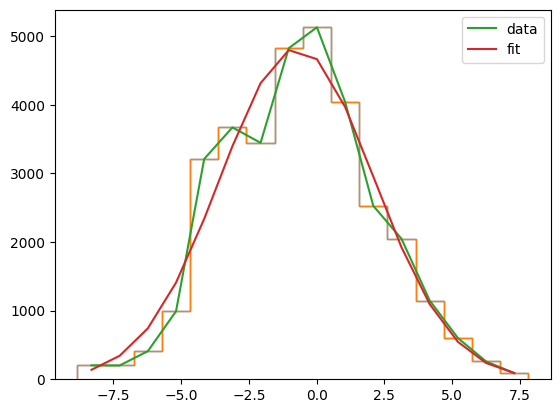

Fit parameters: 
C =  4825.653007714182 +- 235.59217006727602
X_mean = -0.723586756997273 +- 0.16016894850114013
sigma =  2.842414175157387 +- 0.1605581741444066




<Figure size 640x480 with 0 Axes>

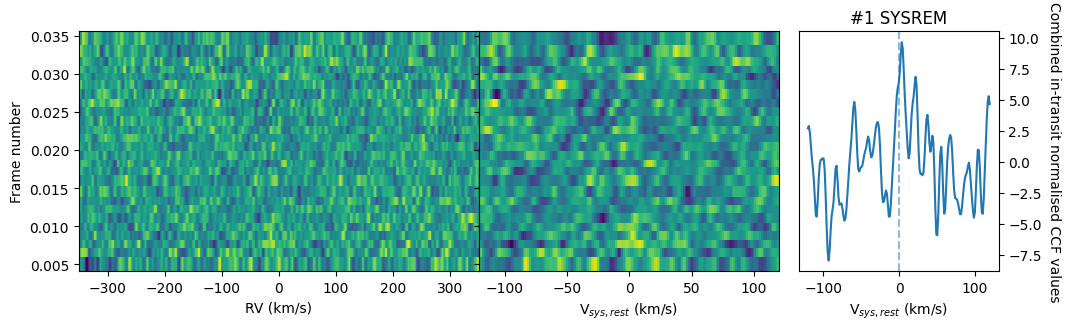

<Figure size 640x480 with 0 Axes>

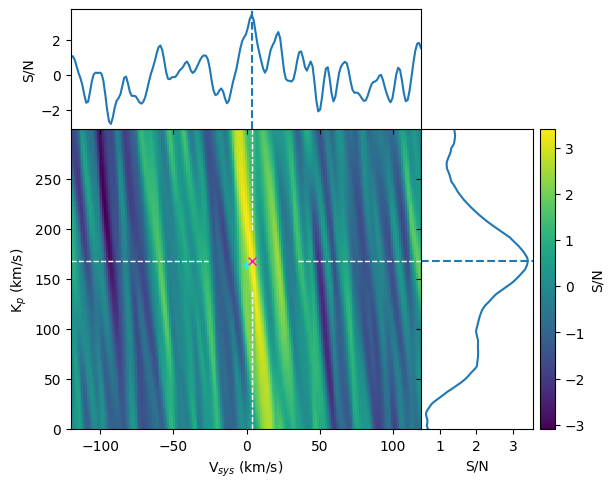

<Figure size 640x480 with 0 Axes>

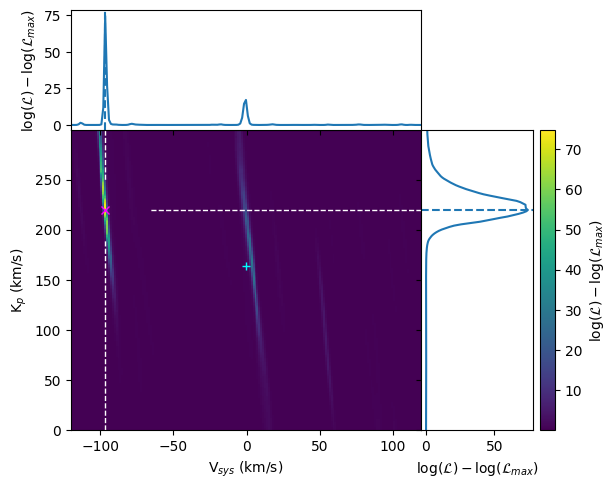

<Figure size 640x480 with 0 Axes>

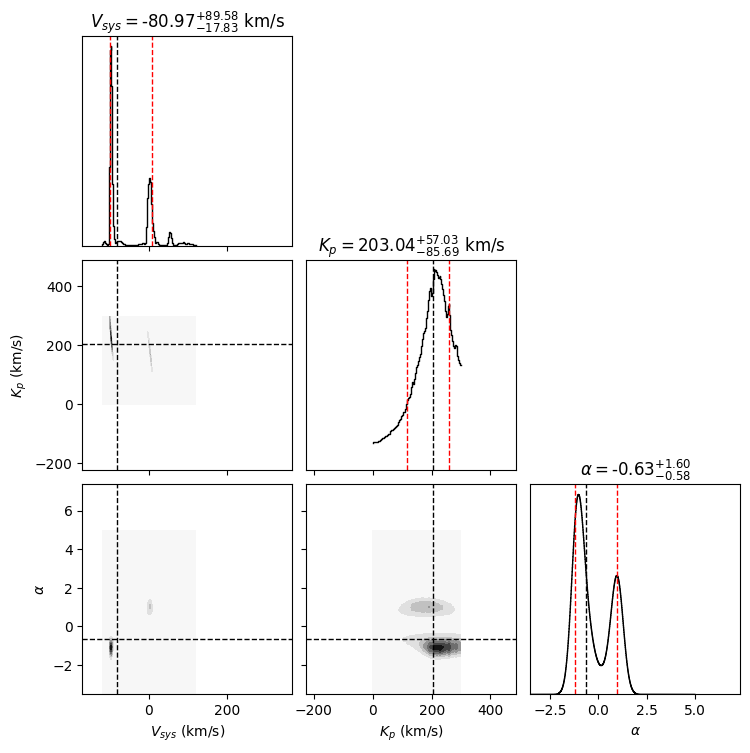

SYSREM 1

Max. peak from S/N map:
Kp = 167.70000000000002 km/s
Vsys = 3.49999999999973 km/s
S/N = 3.41

Max. peak from likelihood distribution:
Kp = 209.3 km/s
Vsys = -96.60000000000005 km/s
Significance = -3.75 (α = -1.12 ± {0.30,0.30})



<Figure size 640x480 with 0 Axes>

In [6]:
sampling = 1.30
RV_sample = np.arange(-350,350,sampling)    # in km/s
Kp_sample = np.arange(0,300,sampling)           # in km/s
Vsys_sample = np.arange(-120,120,sampling)       # in km/s
Kp_planet = 164.27                          # in km/s (calculated from formula given in Exoplanets (Seager, 2010))
Vsys_planet = -17.91                        # in km/s (calculated from stellar RV analysis)
A_sample = np.arange(-5.,5.,0.01)
sys_num = 1

wvdat,fluxdat,errdat = wave_data,flux_data,error_data

frame_remove = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]) # np.arange(0,29,1)
rem = frame_remove
# for rem in frame_remove:
# rem.append(rem_num)
mask_trans = np.delete(out_transit_mask,rem,0)
transit_weight_del = np.delete(transit_weight,rem,0)
phase_del = np.delete(phase,rem,0)
rel_phase_del = np.delete(rel_phase,rem,0)
rvcor_del = np.delete(rvcor,rem,0)
wv_dat = np.delete(wvdat,rem,2)
flux_dat = np.delete(fluxdat,rem,2)
err_dat = np.delete(errdat,rem,2)
print('')
print('################ Removing frame '+str(rem)+' #####################')
snmap_2nd_wo29,snmap_h2o_std = detect_molecules(wv_dat,flux_dat,err_dat,wave_modelmol,flux_modelmol,sys_num,carm_order,
            RV_sample,Kp_sample,Vsys_sample,A_sample,
            Kp_planet,Vsys_planet,transit_weight_del,mask_trans,rvcor_del,phase_del,rel_phase_del,std_brogi=True,plot=True)


################ Removing frame [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] #####################


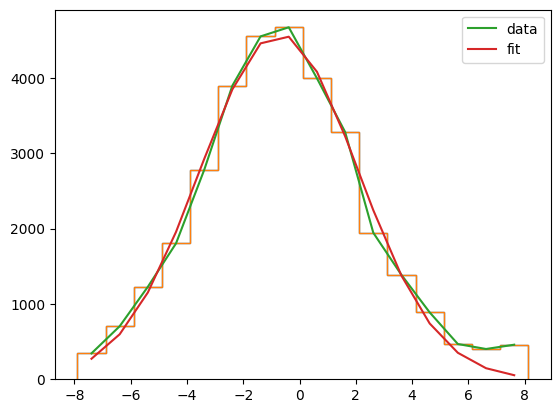

Fit parameters: 
C =  4582.700272837413 +- 103.38014551505034
X_mean = -0.7293009038114792 +- 0.07296819329048679
sigma =  -2.8034497950184054 +- 0.07343251721079491




<Figure size 640x480 with 0 Axes>

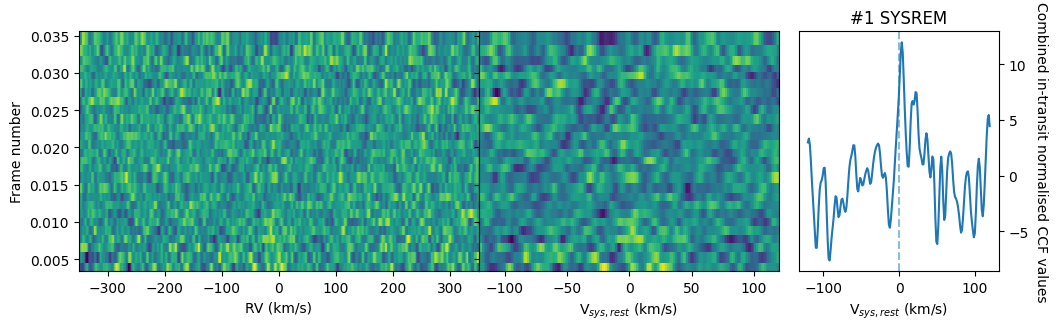

<Figure size 640x480 with 0 Axes>

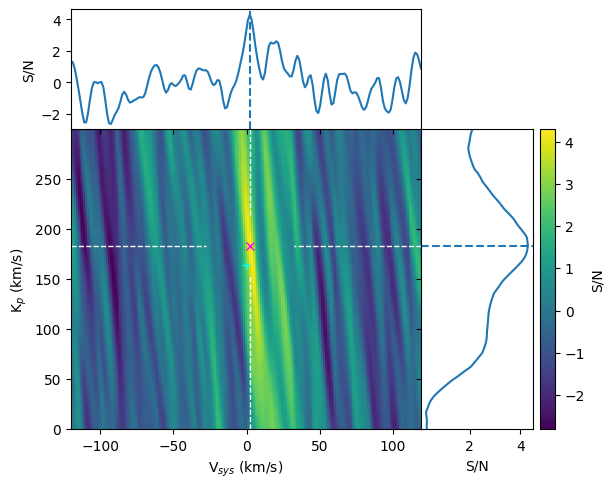

<Figure size 640x480 with 0 Axes>

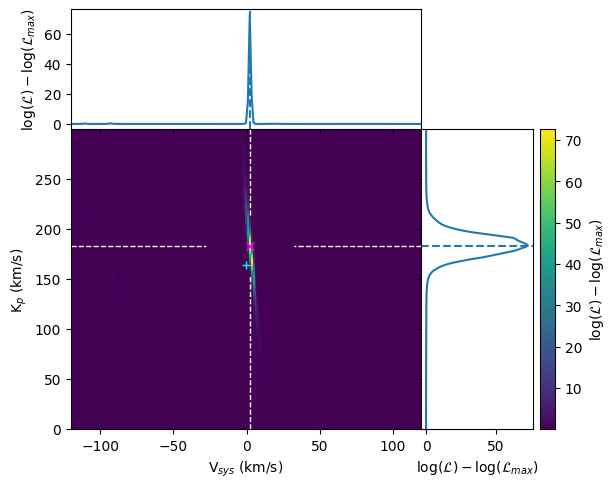

<Figure size 640x480 with 0 Axes>

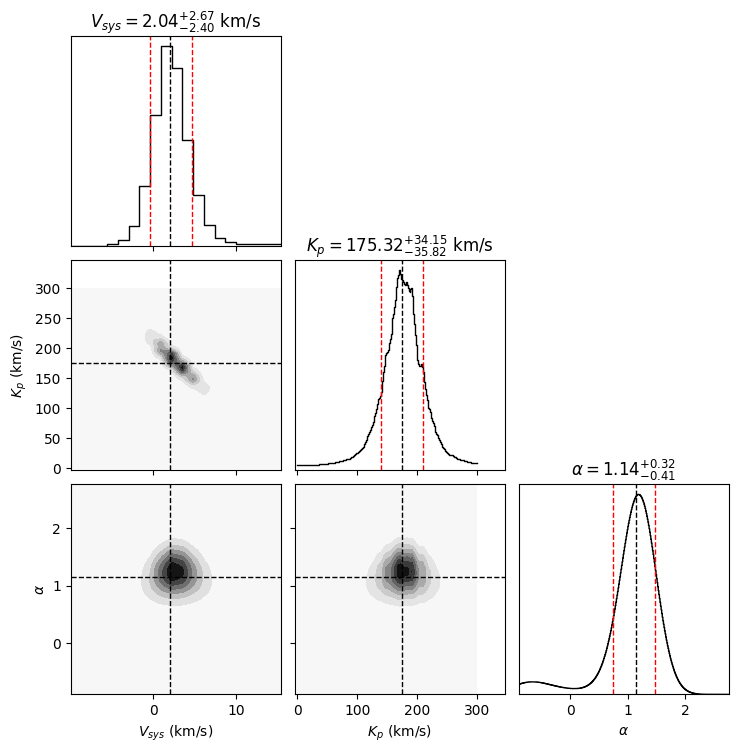

SYSREM 1

Max. peak from S/N map:
Kp = 183.3 km/s
Vsys = 2.199999999999733 km/s
S/N = 4.29

Max. peak from likelihood distribution:
Kp = 171.6 km/s
Vsys = 2.199999999999733 km/s
Significance = 4.27 (α = 1.24 ± {0.29,0.29})



<Figure size 640x480 with 0 Axes>

In [8]:
sampling = 1.30
RV_sample = np.arange(-350,350,sampling)    # in km/s
Kp_sample = np.arange(0,300,sampling)           # in km/s
Vsys_sample = np.arange(-120,120,sampling)       # in km/s
Kp_planet = 164.27                          # in km/s (calculated from formula given in Exoplanets (Seager, 2010))
Vsys_planet = -17.91                        # in km/s (calculated from stellar RV analysis)
A_sample = np.arange(-5.,5.,0.01)
sys_num = 1

wvdat,fluxdat,errdat = wave_data,flux_data,error_data

frame_remove = np.arange(0,29,1)
rem = frame_remove # np.append(frame_remove,[29])
# for rem in frame_remove:
    # rem.append(rem_num)
mask_trans = np.delete(out_transit_mask,rem,0)
transit_weight_del = np.delete(transit_weight,rem,0)
phase_del = np.delete(phase,rem,0)
rel_phase_del = np.delete(rel_phase,rem,0)
rvcor_del = np.delete(rvcor,rem,0)
wv_dat = np.delete(wvdat,rem,2)
flux_dat = np.delete(fluxdat,rem,2)
err_dat = np.delete(errdat,rem,2)
print('')
print('################ Removing frame '+str(rem)+' #####################')
snmap_2nd_with29,snmap_h2o_std = detect_molecules(wv_dat,flux_dat,err_dat,wave_modelmol,flux_modelmol,sys_num,carm_order,
            RV_sample,Kp_sample,Vsys_sample,A_sample,
            Kp_planet,Vsys_planet,transit_weight_del,mask_trans,rvcor_del,phase_del,rel_phase_del,std_brogi=True,plot=True)

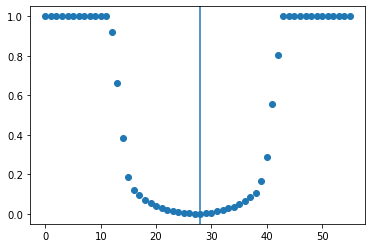

In [ ]:
plt.scatter(np.arange(len(phase)),1-transit_weight)
plt.axvline(x=28)
# plt.axvline(x=30)
# plt.axvline(x=26)


################ Removing frame [55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32
 31 30 29 28] #####################


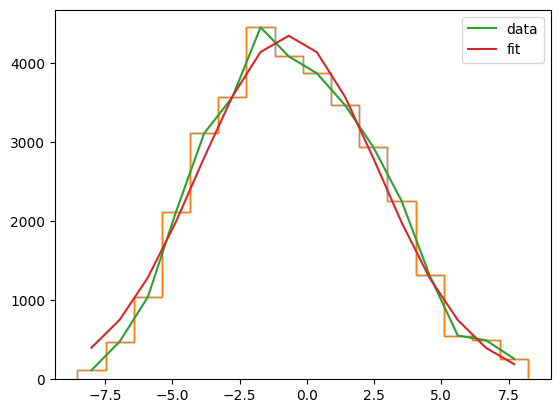

Fit parameters: 
C =  4340.716601441449 +- 121.60748955691449
X_mean = -0.6759928264110093 +- 0.10832273177058141
sigma =  -3.354037309080945 +- 0.11025131216336861




<Figure size 640x480 with 0 Axes>

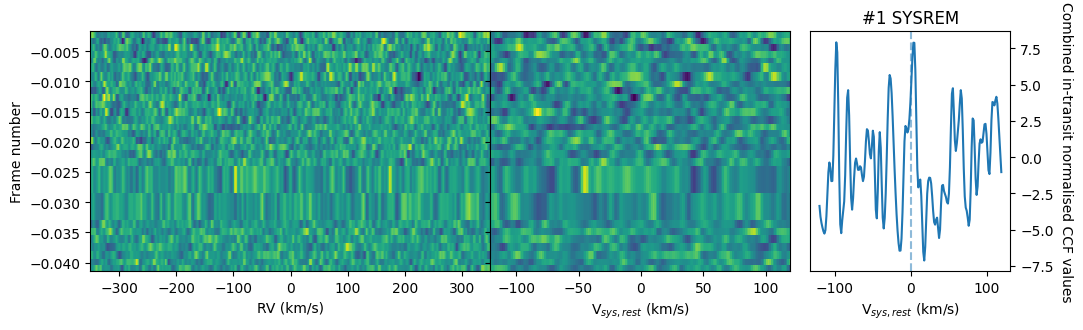

<Figure size 640x480 with 0 Axes>

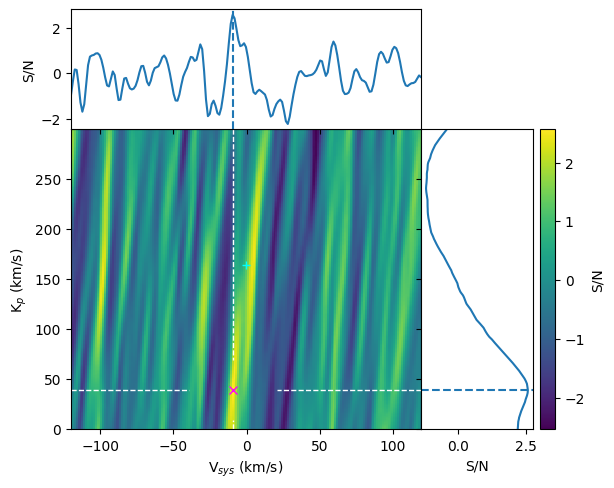

<Figure size 640x480 with 0 Axes>

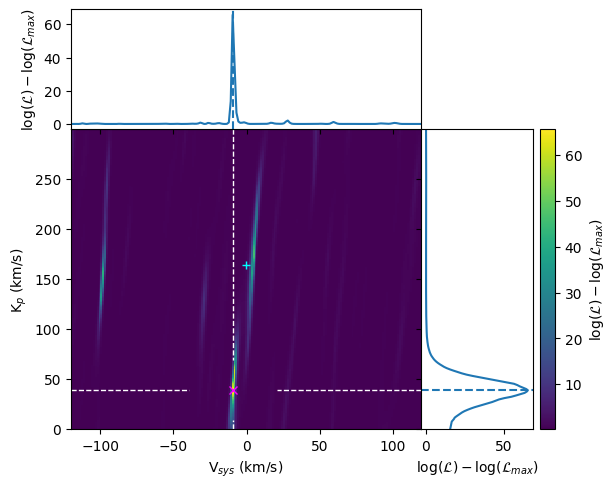

<Figure size 640x480 with 0 Axes>

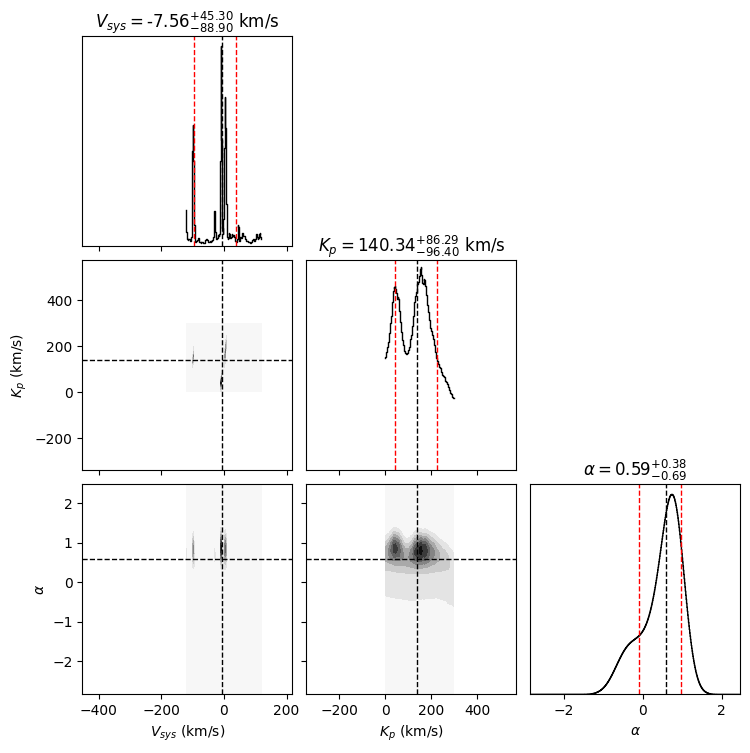

SYSREM 1

Max. peak from S/N map:
Kp = 39.0 km/s
Vsys = -9.500000000000242 km/s
S/N = 2.57

Max. peak from likelihood distribution:
Kp = 156.0 km/s
Vsys = -8.200000000000244 km/s
Significance = 0.9 (α = 0.23 ± {0.26,0.26})



<Figure size 640x480 with 0 Axes>

In [10]:
sampling = 1.30
RV_sample = np.arange(-350,350,sampling)    # in km/s
Kp_sample = np.arange(0,300,sampling)           # in km/s
Vsys_sample = np.arange(-120,120,sampling)       # in km/s
Kp_planet = 164.27                          # in km/s (calculated from formula given in Exoplanets (Seager, 2010))
Vsys_planet = -17.91                        # in km/s (calculated from stellar RV analysis)
A_sample = np.arange(-5.,5.,0.01)
sys_num = 1

wvdat,fluxdat,errdat = wave_data,flux_data,error_data

frame_remove = np.array([55,54,53,52,51,50,49,48,47,46,45,44,43,42,41,40,39,38,37,36,35,34,33,32,31,30,29,28]) # np.arange(55,27,-1)
rem = frame_remove #[]
# for rem_num in frame_remove:
# rem.append(rem_num)
mask_trans = np.delete(out_transit_mask,rem,0)
transit_weight_del = np.delete(transit_weight,rem,0)
phase_del = np.delete(phase,rem,0)
rel_phase_del = np.delete(rel_phase,rem,0)
rvcor_del = np.delete(rvcor,rem,0)
wv_dat = np.delete(wvdat,rem,2)
flux_dat = np.delete(fluxdat,rem,2)
err_dat = np.delete(errdat,rem,2)
print('')
print('################ Removing frame '+str(rem)+' #####################')
snmap_1st,snmap_h2o_std = detect_molecules(wv_dat,flux_dat,err_dat,wave_modelmol,flux_modelmol,sys_num,carm_order,
            RV_sample,Kp_sample,Vsys_sample,A_sample,
            Kp_planet,Vsys_planet,transit_weight_del,mask_trans,rvcor_del,phase_del,rel_phase_del,std_brogi=True,plot=True)

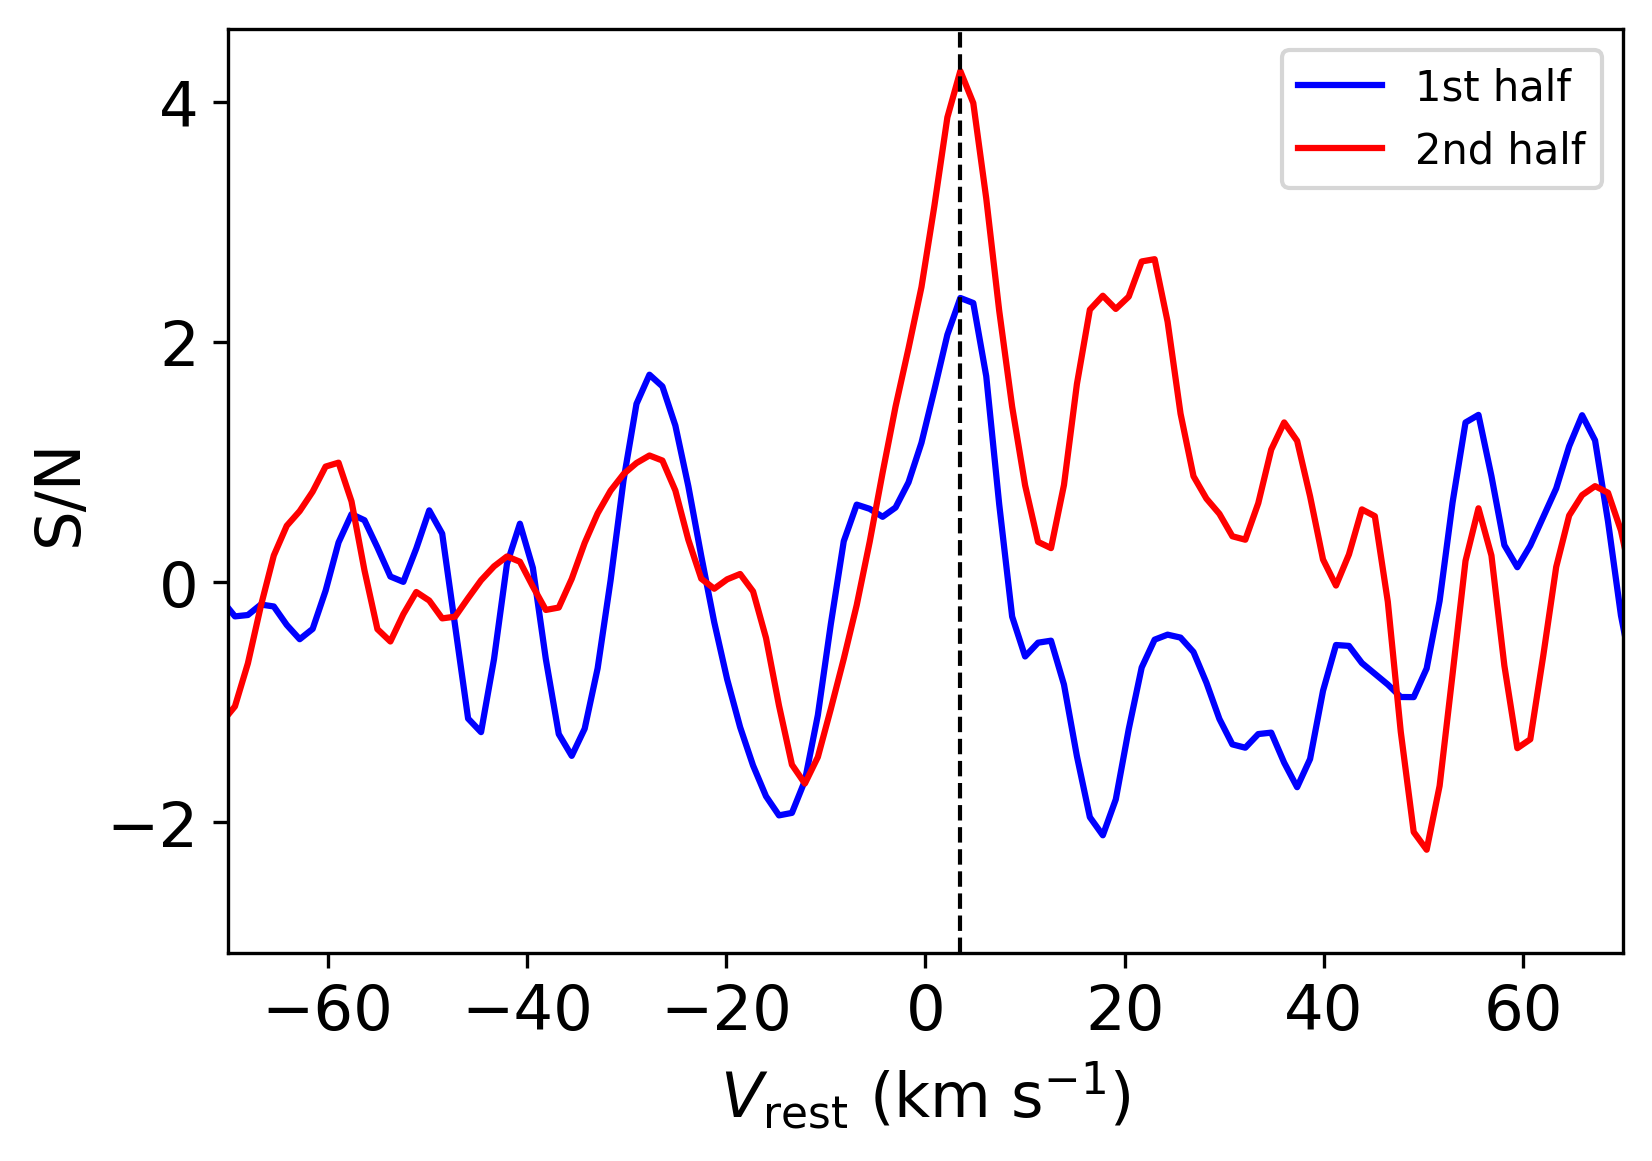

<Figure size 640x480 with 0 Axes>

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    return (np.abs(array - value)).argmin()

kp_snmax = find_nearest(Kp_sample,161.88)

plt.figure(figsize=(6, 4),dpi=300)
plt.plot(Vsys_sample,snmap_1st[0][kp_snmax],label='1st half',c='blue')
# plt.plot(Vsys_sample,snmap_2nd[0][kp_snmax],label='2nd half')

# snmap = snmap_2nd_wo29[0]
# kp_snmax,vsys_snmax = np.unravel_index(snmap.argmax(),snmap.shape)
plt.plot(Vsys_sample,snmap_2nd_with29[0][kp_snmax],label='2nd half',c='red')
# plt.plot(Vsys_sample,snmap_2nd_wo29[0][kp_snmax],label='2nd half w/o frame #44',c='green')

plt.axvline(x=3.5,ls='--',lw=1,c='black')

lbl=15
plt.xlabel(r'$V_\mathrm{rest}$ (km s$^{-1}$)',fontsize=lbl)
plt.ylabel('S/N',fontsize=lbl)
plt.legend()
#plt.yticks([-3,-2,-1,0,1,2,3,4])
plt.xlim(-70,70)
# plt.ylim(-3,4.5)
plt.tick_params(axis='both', which='major', labelsize=lbl)
plt.savefig("figures/separate_half.pdf",format="pdf",dpi=200,bbox_inches="tight",pad_inches=0.1)
plt.show()
plt.clf()